In [3]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
#from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
#from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

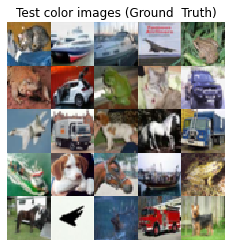

In [4]:
# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# display the 1st 25 input images (color and gray)
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()

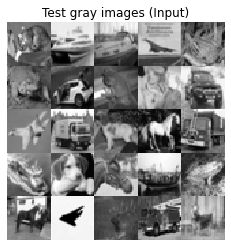

In [5]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray  = rgb2gray(x_test)

# display grayscale version of test images
imgs = x_test_gray[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In [6]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [8]:
# network parameters
input_shape = (img_rows, img_cols, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
print(shape)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,419,648
Trainable params: 1,419,648
Non-trainable params: 0
_________________________________________________

In [9]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 1)         577 

In [8]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# train the autoencoder
autoencoder.fit(x_train_gray, x_train, validation_data=(x_test_gray, x_test), epochs=30, batch_size=batch_size)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 256)               1418496   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1563/1563 [==============================] - 78s 50ms/step - loss: 0.0154 - val_loss: 0.0108
Epoch 2/30
1563/1563 [==============================] - 79s 51ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 3/30
1563/1563 [==============================] - 80s 51ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 4/30
1563/1563 [==============================] - 80s 51m

In [1]:
# display the 1st 25 colorized images
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.show()

imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()

NameError: name 'x_decoded' is not defined